*This notebook was created by [Sergey Tomin](http://www.xfel.eu/organization/staff/tomin_sergey/). Source and license info is on [GitHub](https://github.com/iagapov/ocelot/tree/dev/docs). May 2017.*

## Tutorial N5. Coherent Synchrotron Radiation.
*Second order tracking with CSR effect of the 200k particles.*

As an example, we will use bunch compressor BC2 of the European XFEL Injector. 

The CSR module uses a fast ‘projected’ 1-D method from CSRtrack code and follows the approach presented in {[Saldin et al 1998](http://www.sciencedirect.com/science/article/pii/S0168900298006238), [Dohlus 2003](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.233.564&rep=rep1&type=pdf), [Dohlus 2004](https://accelconf.web.cern.ch/accelconf/f04/papers/MOCOS05/MOCOS05.PDF)}. The particle tracking uses matrices up to the second order. CSR wake is calculated continuously through beam lines of arbitrary flat geometry. The transverse self-forces are neglected completely. The method calculates the longitudinal self-field of a one-dimensional beam that is obtained by a projection of the ‘real’ three-dimensional beam onto a reference trajectory. A smooth one-dimensional charge density is calculated by binning and filtering, which is crucial for the stability and accuracy of the simulation, since the instability is sensitive to high frequency components in the charge density. 


#### This example will cover the following topics:
* Initialization of the CSR object and the places of it applying
* tracking of second order with CSR effect.

#### Requirements 
* in.fmt1    - input file, initial beam distribution in CSRtrack format (was obtained from s2e simulation performed with ASTRA/CSRtrack).
* out.fmt1 - output file, beam distribution after BC2 bunch compressor (was obtained with CSRtrack)

In [1]:
# the output of plotting commands is displayed inline within frontends, 
# directly below the code cell that produced it
%matplotlib inline

from time import time 

# this python library provides generic shallow (copy) and deep copy (deepcopy) operations 
from copy import deepcopy

# import from Ocelot main modules and functions
from ocelot import *

# import from Ocelot graphical modules
from ocelot.gui.accelerator import *

# load beam distribution
# this function convert CSRtrack beam distribution to Ocelot format - ParticleArray. ParticleArray is designed for tracking.
# in order to work with converters we have to import specific module from ocelot.adaptors
from ocelot.adaptors.csrtrack2ocelot import *

cs.py: module PYFFTW is not install. Install it if you want speed up your calculation
initializing ocelot...


### Load beam distribution from CSRtrack format

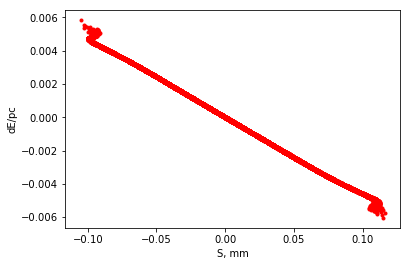

In [2]:
# load and convert CSRtrack file to OCELOT beam distribution
# p_array_i = csrtrackBeam2particleArray("in.fmt1", orient="H")

# save ParticleArray to compresssed numpy array 
# save_particle_array("test.npz", p_array_i)
p_array_i = load_particle_array("csr_beam.npz")

# show the longitudinal phase space
plt.plot(-p_array_i.tau()*1000, p_array_i.p(), "r.")
plt.xlabel("S, mm")
plt.ylabel("dE/pc")

### create BC2 lattice

In [3]:
b1 = Bend(l = 0.500094098121, angle=-0.03360102249639, e1=0.0, e2=-0.03360102249639, gap=0,    tilt=0, fint=0.0, fintx=0.0, eid='BB.393.B2')
b2 = Bend(l = 0.500094098121, angle=0.03360102249639, e1=0.03360102249639, e2=0.0, gap=0,  tilt=0, fint=0.0, fintx=0.0, eid='BB.402.B2')
b3 = Bend(l = 0.500094098121, angle=0.03360102249639, e1=0.0, e2=0.03360102249639, gap=0, tilt=0, fint=0.0, fintx=0.0, eid='BB.404.B2')
b4 = Bend(l = 0.500094098121, angle=-0.03360102249639, e1=-0.03360102249639, e2=0.0, gap=0,    tilt=0, fint=0.0, fintx=0.0, eid='BB.413.B2')

d_slope = Drift(l=8.5/np.cos(b2.angle))

start_csr = Marker()
stop_csr = Marker()

# define cell frome the bends and drifts
cell = [start_csr, Drift(l=0.1), b1 , d_slope  , b2, Drift(l=1.5) , b3, d_slope, b4, Drift(l= 1.), stop_csr]

#### Initialization tracking method and MagneticLattice object

In [4]:
# initialization of tracking method
method = MethodTM()

# for second order tracking we have to choose SecondTM 
method.global_method = SecondTM

# for first order tracking uncomment next line
# method.global_method = TransferMap

lat = MagneticLattice(cell, method=method)

### Create CSR object 

In [5]:
csr = CSR()
csr.n_bin = 300
csr.m_bin = 5
csr.sigma_min = 0.2e-6

### Track particles with and without CSR effect

In [6]:
navi = Navigator(lat)

# track witout CSR effect 
p_array_no = deepcopy(p_array_i)
print("\n tracking without CSR effect .... ")
start = time()
tws_no, p_array_no = track(lat, p_array_no, navi)
print("\n time exec:", time() - start, "sec")

# again create Navigator with needed step in [m]
navi = Navigator(lat)
navi.unit_step = 0.1 # m

# add csr process to navigator with start and stop elements
navi.add_physics_proc(csr, start_csr, stop_csr)

# tracking 
start = time()
p_array_csr = deepcopy(p_array_i)
print("\n tracking with CSR effect .... ")
tws_csr, p_array_csr = track(lat, p_array_csr, navi)
print("\n time exec:", time() - start, "sec")


 tracking without CSR effect .... 
z = 21.6099776532 / 21.6099776532 : applied:  
 time exec: 1.1710667610168457 sec

 tracking with CSR effect .... 
z = 21.6099776532 / 21.6099776532 : applied: CSR
 time exec: 288.1414806842804 sec


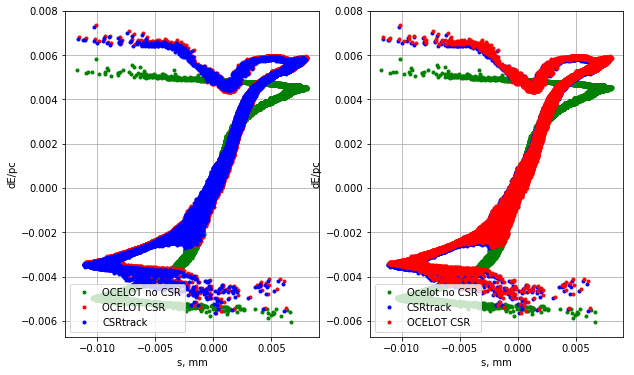

In [7]:
# recalculate reference particle 
from ocelot.cpbd.beam import *

recalculate_ref_particle(p_array_csr)
recalculate_ref_particle(p_array_no)

# load and convert CSRtrack file to OCELOT beam distribution 
# distribution after BC2
# p_array_out = csrtrackBeam2particleArray("out.fmt1", orient="H")
# save ParticleArray to compresssed numpy array 
# save_particle_array("scr_track.npz", p_array_out)
p_array_out = load_particle_array("scr_track.npz")

# standard matplotlib functions 

plt.figure(2, figsize=(10, 6))
plt.subplot(121)
plt.plot(p_array_no.tau()*1000, p_array_no.p(), 'g.', label="OCELOT no CSR")
plt.plot(p_array_csr.tau()*1000, p_array_csr.p(), 'r.', label="OCELOT CSR")
plt.plot(p_array_out.tau()*1000, p_array_out.p(), 'b.', label="CSRtrack")
plt.legend(loc=3)
plt.xlabel("s, mm")
plt.ylabel("dE/pc")
plt.grid(True)


plt.subplot(122)
plt.plot(p_array_no.tau()*1000, p_array_no.p(), 'g.', label="Ocelot no CSR")
plt.plot(p_array_out.tau()*1000, p_array_out.p(), 'b.', label="CSRtrack")
plt.plot(p_array_csr.tau()*1000, p_array_csr.p(), 'r.', label="OCELOT CSR")
plt.legend(loc=3)
plt.xlabel("s, mm")
plt.ylabel("dE/pc")
plt.grid(True)